In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
import pandas as pd
from smartcampaign import SmartCampaignBase
from smartcampaign.tools import *
import os

#
# Init V1 framework datasource
#
from exobuilder.data.exostorage import EXOStorage
from scripts.settings import *

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)

CAMPAIGN_DICT = {
    'name': "SmartCampaignDebug",
    'alpha_risk_type': 'atr',
    'alpha_risk_period': 100,

    'campaign_risk_type': 'atrmax',
    'campaign_risk_period': 100,

    'alphas': {
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_ZN_EXO_PutSpread_DynKel_longs_DSP_BandPass__Bullish_2_Sept_7_21': {'tag': ''},
        'ZN_ContFut_Long_Strategy_DSP_BandPass__Bullish_2_Sept_7__hedged': {
            'tag': '',
            'alphas': {
                'ZN_ContFut_Long_Strategy_DSP_BandPass__Bullish_2_Sept_7_custom': 1.0,
                '!NEW_AlphaV1Exposure_HedgedBy_V2_US_ZN_EXOSemiFuture_DynKel_20_60_longs_DSP_BandPass__Bullish_2_Sept_7_Oct_6': 1.0,
            }
        }
    }
}

# Loading V1 and V2 alphas
alphas_list = SmartCampaignBase.get_alphas_list_from_settings(CAMPAIGN_DICT)

if os.path.isfile('campaign_df.pkl'):
    df_alphas_equities = pd.read_pickle('campaign_df.pkl')
    cached_cols = df_alphas_equities.columns
else:
    cached_cols = []

if set(cached_cols) != set(alphas_list):
    # Refresh the cache
    alphas_series_dict = storage.swarms_data(alphas_list, load_v2_alphas=True)
    df_alphas_equities = pd.DataFrame({k: v['swarm_series']['equity'] for k,v in alphas_series_dict.items()})
    df_alphas_equities.to_pickle('campaign_df.pkl')

#
# Init Smart Campaign
#
scmp = SmartCampaignBase(CAMPAIGN_DICT, df_alphas_equities)





In [11]:
%%timeit
alpha_adj_weights, alpha_cmp_weights, cmp_risk = scmp.calculate()


100 loops, best of 3: 3.61 ms per loop


In [59]:
BACKTESTER_SETTINGS = {
    'start_date': datetime.datetime(2014, 1, 1),
    'initial_capital': 50000,
    'target_risk_percent': 0.01,    
}

bt_dict = scmp.backtest(**BACKTESTER_SETTINGS)

NetProfit $                     23421.54
NetProfit %                        46.84%

MaxDD $                        -21809.08
MaxDD %                           -33.41%

MaxATR $                          692.17
Q95% ATR $                        673.23
Avg ATR $                         598.83

MaxATR %                            1.07%
Q95% ATR %                          1.01%
Avg ATR %                           0.85%


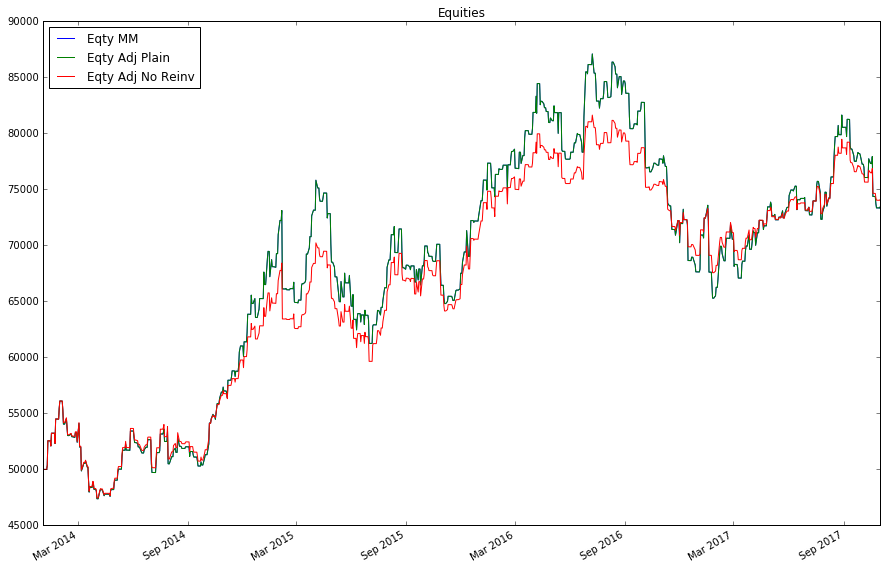

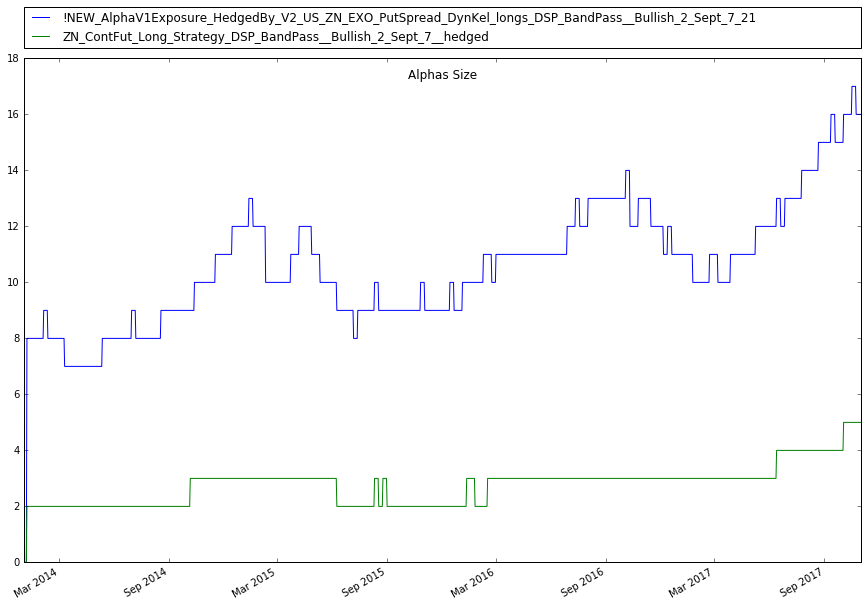

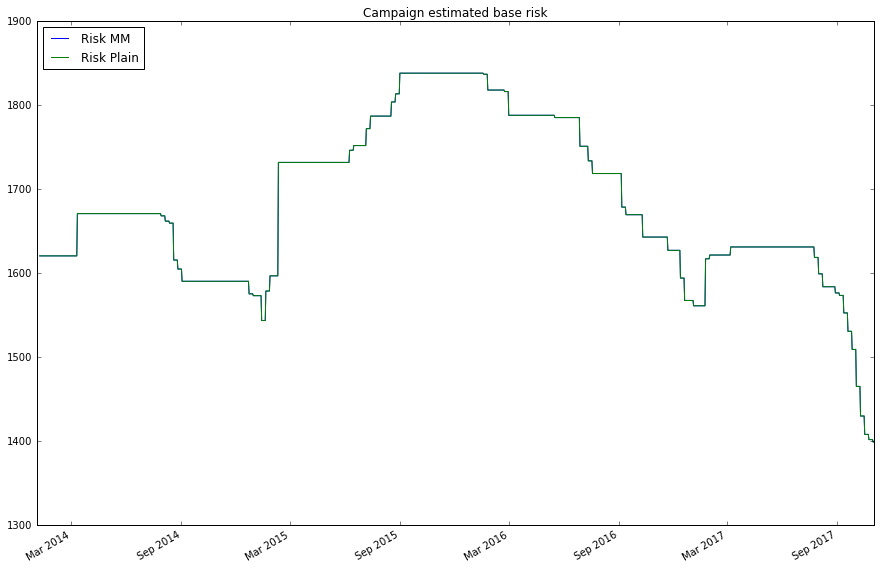

In [61]:
scmp.report(bt_dict)

In [34]:
#bt_dict['campaign_alphas_size'].plot()

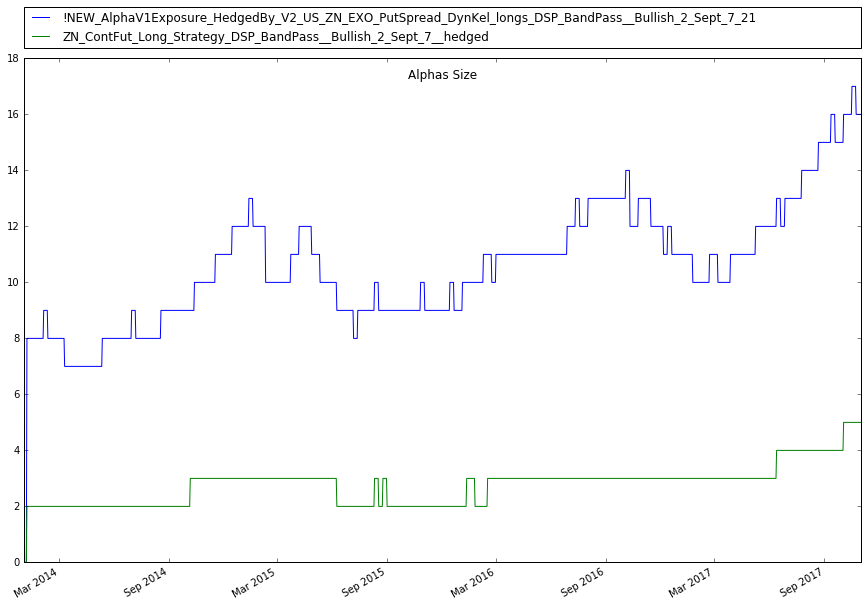

In [54]:
figsize(15, 10)

bt_dict['campaign_alphas_size'].plot().legend(bbox_to_anchor=(0,1.02,1,0.2), 
                                              loc="lower left",
                                              mode="expand", 
                                              borderaxespad=0, ncol=1);

title('Alphas Size', y=0.95);


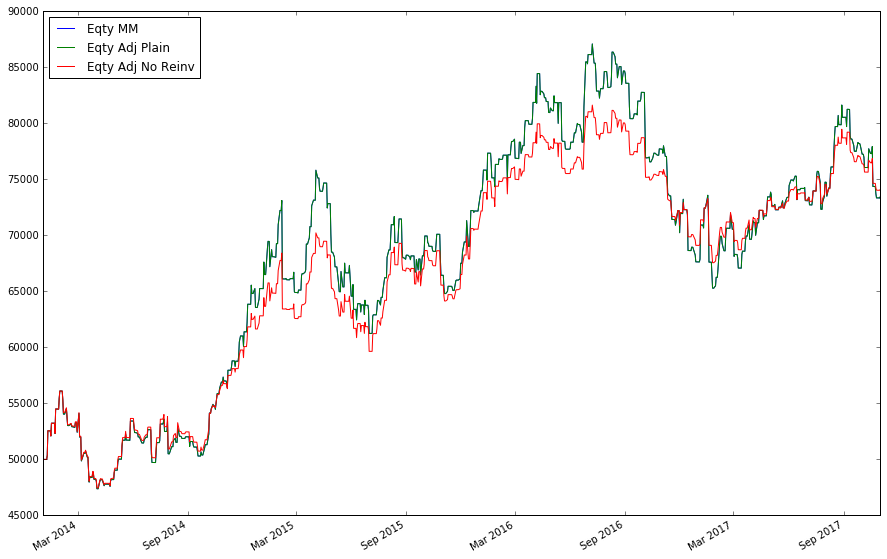

In [36]:
bt_dict['equity_mm'].plot(label='Eqty MM')
bt_dict['equity_plain_adj'].plot(label='Eqty Adj Plain')
bt_dict['equity_plain_adj_noreinv'].plot(label='Eqty Adj No Reinv')
legend(loc=2)

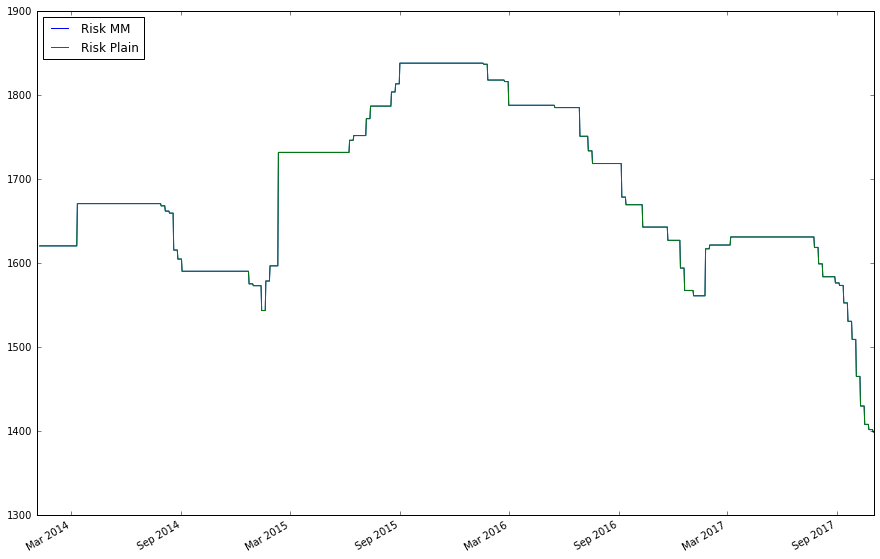

In [37]:
bt_dict['campaign_estimated_base_risk'].plot(label='Risk MM')
bt_dict['campaign_estimated_base_risk_plain'].plot(label='Risk Plain')
legend(loc=2)
